### Overlay Image using homography and perspective transformation

This notebook demonstrates how one can identify object and overlay annotation and pointer arrow

In [37]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

import math 

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from pylab import rcParams
rcParams['axes.xmargin'] = 0
rcParams['axes.ymargin'] = 0
rcParams['figure.figsize'] = (14,6)


This function takes the X and Y corodinate as input and decides how the orientation of image needs to happen before it is added to main image

In [38]:
def alignOverlayImage(x,y):
    global alignment,currnetDirection,textDirection,newX,newY,overlayItem
    alignment = ""
    currentDirection=""
    textDirection = ""
    
    alignment = "RH"
    if (x >= (obj.shape[1]/2)):
        alignment = "RH"
        textDirection = "LEFT"
    else:
        alignment = "LH"
        textDirection = "RIGHT"
        
    print("Alignment is", alignment)
    
    if (y >= (obj.shape[0]/2)):
        if (alignment=="RH"):
            alignment  ="II"
        else:
            alignment = "III"
    else:
        if (alignment=="RH"):
            alignment  ="I"
        else:
            alignment = "IV"
            
    if (alignment == "I"):
        if (y > (obj.shape[1] - x)):
            alignment = "RIGHT"
            if (currentDirection != "RIGHT"):
                newX = x - overlayItem.shape[1]
                newY = y - (overlayItem.shape[0] / 2)
                currentDirection = "RIGHT"
                overlayItem=cv2.rotate(overlayItem, rotateCode=cv2.ROTATE_90_CLOCKWISE)
                print("Quadrant: I, Side :RIGHT")
        else:
            alignment = "TOP"
            if (currentDirection != "TOP"):
                newX = x - (overlayItem.shape[1]/2)
                newY = y
                currentDirection = "TOP"
                print("Quadrant: I, Side :TOP")
        #check if they lay on any of the top or right corner
        if (x >= (obj.shape[1] - (overlayItem.shape[1] / 2))):
            newX = obj.shape[1] - overlayItem.shape[1]
        if (y <= (overlayItem.shape[0] / 2)):
            newY = 0
        
    if (alignment == "II"):
        if ((obj.shape[0] - y) > (obj.shape[1] - x)):
            alignment = "RIGHT"
            if (currentDirection != "RIGHT"):
                newX = x - overlayItem.shape[1]
                newY = y - (overlayItem.shape[0] / 2)
                currentDirection = "RIGHT"
                overlayItem=cv2.rotate(overlayItem, rotateCode=cv2.ROTATE_90_CLOCKWISE)
                print("Quadrant: II, Side :RIGHT")
        else:
            alignment = "BOTTOM"
            if (currentDirection != "BOTTOM"):
                newX = x - (overlayItem.shape[1] / 2)
                newY = y - overlayItem.shape[0]
                currentDirection = "BOTTOM"
                overlayItem=cv2.rotate(overlayItem, rotateCode=cv2.ROTATE_180)
                print("Quadrant: II, Side :BOTTOM")
            
        #check if they lay on any of right or bottom corner
        if (x >= (obj.shape[1] - (overlayItem.shape[1]/2))):
            newX = obj.shape[1] - overlayItem.shape[1]
        if (y >= (obj.shape[0] - (overlayItem.shape[0] / 2))):
            newY = obj.shape[0] - overlayItem.shape[0]
        
    if (alignment == "III"):
        if ((obj.shape[0] - y) > x):
            alignment = "LEFT"
            if (currentDirection != "LEFT"):
                newX = x 
                newY = y - (overlayItem.shape[0] / 2)
                currentDirection = "LEFT"
                overlayItem = cv2.rotate(overlayItem, rotateCode=cv2.ROTATE_90_COUNTERCLOCKWISE)
                print("Quadrant: III, Side :LEFT")
        else:
            alignment = "BOTTOM"
            if (currentDirection != "BOTTOM"):
                newX = x - (overlayItem.shape[1] / 2)
                newY = y - overlayItem.shape[0] 
                currentDirection = "BOTTOM"
                overlayItem=cv2.rotate(overlayItem, rotateCode=cv2.ROTATE_180)
                print("Quadrant: III, Side :BOTTOM")
                   
        #check if point lay on bottom or left corner
        if (x <= (overlayItem.shape[1] / 2)):
            newX = 0
        if (y >= (obj.shape[0] - (overlayItem.shape[0] / 2))):
            newY = obj.shape[0] - overlayItem.shape[0]

    if (alignment == "IV"):
        if (y > x):
            alignment = "LEFT"
            if (currentDirection != "LEFT"):
                newX = x 
                newY = y - (overlayItem.shape[0] / 2)
                currentDirection = "LEFT"
                overlayItem = cv2.rotate(overlayItem, rotateCode=cv2.ROTATE_90_COUNTERCLOCKWISE)
                print("Quadrant: IV, Side :LEFT")
        else:
            alignment = "TOP"
            if (currentDirection != "TOP"):
                newX = x - (overlayItem.shape[1] / 2)
                newY = y
                currentDirection = "TOP"
                print("Quadrant: IV, Side :TOP")
        if (x <= (overlayItem.shape[1] / 2)):
            newX = 0
        if (y <= (overlayItem.shape[0] / 2)):
            newY = 0

This function will add small overlay image on bigger scene image. (this will work with alpha values zero and one)

In [39]:
def overlayFunction(src , overlay):
    h,w,_ = src.shape  # Size of foreground    
    #loop over all pixels and apply the blending equation
    for i in range(h):
        for j in range(w):
            alpha = float(overlay[i][j][3]/255.0) # read the alpha channel 
            if alpha!=0:
                src[i][j] = overlay[i][j][:4]
    return src

This finction will alighn text either on right hand side or left handside based on the arrow position

In [40]:
def textXY(tX,tY):
    global textToAnnotate,textColor,textFont,fontSize,fontThickness,textDirection
    space = 10
    textSize = cv2.getTextSize(textToAnnotate, textFont, fontSize, fontThickness)[0]
    height = textSize[1]
    width = textSize[0]
 
    if (textDirection =="LEFT"):
        x = tX - (width + space)
        y = tY + height + (50-height)/2
    else:
        x = tX + (50 + space)
        y = tY + height + (50-height)/2
    return x,y

This function will add image in addition to arrow pointer and text.

In [41]:
def imageXY(tX,tY):
    global textDirection,stepImage
    space = 10
    
    height = stepImage.shape[0]
    width = stepImage.shape[1]

    if (textDirection =="LEFT"):
        x = tX - (width + space)
        y = tY + height + (50-height)/2
    else:
        x = tX + (50 + space)
        y = tY + height + (50-height)/2
    return x,y

ORB object detection

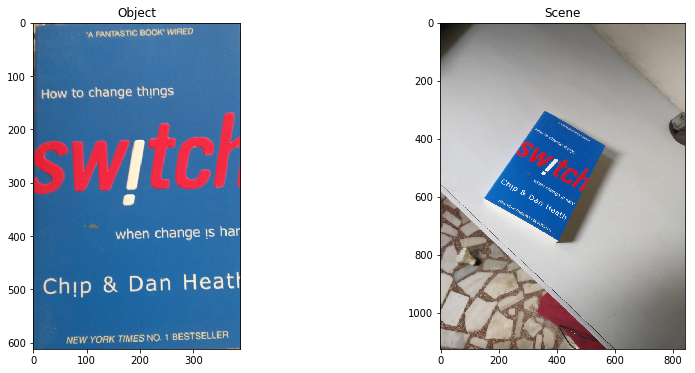

In [42]:
obj = cv2.imread('images/object.png')
obj = cv2.cvtColor(obj, cv2.COLOR_BGR2RGB)

scn = cv2.imread('images/scene.png')
scn = cv2.cvtColor(scn, cv2.COLOR_BGR2RGB)

orb = cv2.ORB_create()
kp1 = orb.detect(obj,None)
kp2 = orb.detect(scn,None)

kp1,des1 = orb.compute(obj,kp1)
kp2,des2 = orb.compute(scn,kp2)

# draw only keypoints location,not size and orientation
img1 = cv2.drawKeypoints(obj, kp1, None, color=(0,255,0), flags=0)
img2 = cv2.drawKeypoints(scn, kp2, None, color=(0,255,0), flags=0)

plt.subplot(121),plt.imshow(obj),plt.title('Object')
plt.subplot(122),plt.imshow(scn),plt.title('Scene')
plt.show()

Brute force Matching algorithm

In [43]:
# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
# Match descriptors.
matches = bf.match(des1,des2)
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)
# Draw first 10 matches.
img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches,None, flags=2)
#plt.imshow(img3),plt.show()

Find Homograohy so that overlay Image can be transformed

In [44]:
## extract the matched keypoints
src_pts  = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
dst_pts  = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1,1,2)

## find homography matrix and do perspective transform
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)



Create overlay Mat and then transform it using warpPerspective

Alignment is LH
Quadrant: III, Side :LEFT
60 511.0


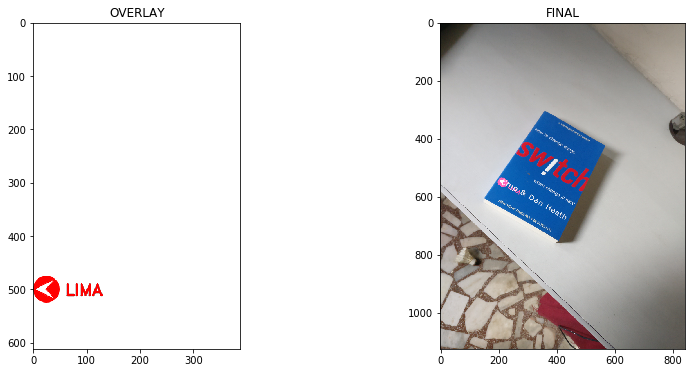

In [45]:
overlayItem = cv2.imread('images/overlay.png',cv2.IMREAD_UNCHANGED)
#print('channels',overlayItem.shape)
overlayItem = cv2.cvtColor(overlayItem, cv2.COLOR_BGRA2RGBA)

stepImage = cv2.imread('images/step_2.png',cv2.IMREAD_UNCHANGED)
#print('channels',stepImage.shape)
stepImage = cv2.cvtColor(stepImage, cv2.COLOR_BGRA2RGBA)
#add pointer at x=200 and y=5
X=10
Y=500

# get properly oriented image based on its location on object image
alignOverlayImage(X,Y)

#create blank overlay image and add overlay item to it
h1,w1 = obj.shape[:2]
overlayImage = np.zeros((h1,w1,4), np.uint8)
overlayImage[int(newY):int(newY) + overlayItem.shape[0], int(newX):int(newX) + overlayItem.shape[1]] = overlayItem

textToAnnotate = "LIMA"
textColor = (255,0,0,255)
textFont = cv2.FONT_HERSHEY_DUPLEX
fontSize = 1
fontThickness = 2
textX,textY = textXY(int(newX),int(newY))
print (textX,textY)

cv2.putText(overlayImage,textToAnnotate , (int(textX), int(textY)),textFont , 
                                           fontSize, textColor, fontThickness, cv2.LINE_AA)

#do transformation
h2,w2 = scn.shape[:2]
xOverlayImage = cv2.warpPerspective(overlayImage,M,(w2,h2))

#add images
scn = cv2.cvtColor(scn, cv2.COLOR_RGB2RGBA)
#R,G,B,alpha= cv2.split(xOverlayImage)
#alpha[:] = 0
#xOverlayImage = cv2.merge((R,G,B,alpha))

final = cv2.add(scn,xOverlayImage)
#final = overlayFunction(scn,xOverlayImage)
plt.subplot(121),plt.imshow(overlayImage),plt.title('OVERLAY')
plt.subplot(122),plt.imshow(final),plt.title('FINAL')
plt.show()